In [1]:
%cd ..
%ls

/home/nas3_userJ/dmkim/TSADBench
analysis/     data/  hptune/   models/   qual/       scripts/
cfgs/         EDA/   logs/     outputs/  README.md*  utils/
checkpoints/  Exp/   main.py*  plots/    results/    wandb/


In [2]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
from utils.metrics import get_auroc, get_summary_stats

In [3]:
from torch import optim

In [4]:
from models.MLP import MLP
import matplotlib.pyplot as plt

In [5]:
import wandb
import hydra
from omegaconf import DictConfig

from utils.logger import make_logger
from utils.argpass import prepare_arguments, configure_exp_id
from utils.tools import SEED_everything

import warnings
from data.load_data import DataFactory
from Exp.SklearnBaselines import *
from Exp.ReconBaselines import *
from Exp.Baselines import *

from easydict import EasyDict as edict
import yaml
import re

warnings.filterwarnings("ignore")

In [6]:
def get_metrics(gt, anomaly_scores, threshold):
    result = {}
    # AUROC
    auc = get_auroc(gt, anomaly_scores, threshold)
    result.update({"AUC": auc})

    # F1
    pred = (anomaly_scores > threshold).astype(int)
    metrics = get_summary_stats(gt, pred)
    result.update(metrics)

    return result

In [7]:
def plot_anomaly(ax, test_y):
    s, e = None, None
    for i in range(len(test_y)):
        if test_y[i] == 1 and s is None:
            s = i
        elif test_y[i] == 0 and s is not None:
            e = i - 1
            if (e - s) > 0:
                ax.axvspan(s, e, facecolor='red', alpha=0.5)
            else:
                ax.axvspan(s-0.5, s+0.5, facecolor='red', alpha=0.5)
            s, e = None, None

In [8]:
model = "MLP"
cfg = {}
loader = yaml.SafeLoader
loader.add_implicit_resolver(
    u'tag:yaml.org,2002:float',
    re.compile(u'''^(?:
     [-+]?(?:[0-9][0-9_]*)\\.[0-9_]*(?:[eE][-+]?[0-9]+)?
    |[-+]?(?:[0-9][0-9_]*)(?:[eE][-+]?[0-9]+)
    |\\.[0-9_]+(?:[eE][-+][0-9]+)?
    |[-+]?[0-9][0-9_]*(?::[0-5]?[0-9])+\\.[0-9_]*
    |[-+]?\\.(?:inf|Inf|INF)
    |\\.(?:nan|NaN|NAN))$''', re.X),
    list(u'-+0123456789.'))

with open("cfgs/defaults.yaml", "r") as file:
    basic_config = yaml.load(file, Loader=loader)
    cfg.update(basic_config)
with open(f"cfgs/model/{model}.yaml", "r") as file:
    model_config = yaml.load(file, Loader=loader)
    cfg.update({"model": model_config})

In [9]:
cfg['dataset'] = 'MSL'

In [10]:
args = prepare_arguments(cfg)
args.model.latent_dim = 128
args.window_size = 12
args.eval_batch_size = 1
args.dataset = "MSL"
print(args)

{'exp_id': 'MLP_MSL', 'dataset': 'MSL', 'batch_size': 64, 'eval_batch_size': 1, 'window_size': 12, 'stride': 1, 'eval_stride': 12, 'scaler': 'std', 'lr': 0.001, 'epochs': 30, 'log_freq': 10, 'checkpoint_path': './checkpoints/MLP_MSL', 'log_path': './logs/MLP_MSL', 'output_path': './outputs/MLP_MSL', 'plot_path': './plots/MLP_MSL', 'result_path': './results/MLP_MSL', 'thresholding': 'oracle', 'load_pretrained': True, 'eval_every_epoch': False, 'anomaly_reduction_mode': 'mean', 'defaults': [{'model': 'OCSVM'}], 'model': {'name': 'MLP', 'latent_dim': 128}, 'home_dir': '.', 'device': device(type='cuda')}


In [11]:
logger = make_logger(os.path.join(args.log_path, f'{args.exp_id}.log'))
logger.info(f"Configurations: {args}")

# Data
logger.info(f"Preparing {args.dataset} dataset...")
datafactory = DataFactory(args, logger)
train_dataset, train_loader, test_dataset, test_loader = datafactory()
args.num_channels = train_dataset.X.shape[1]

[2023-03-14 07:52:07,450] Configurations: {'exp_id': 'MLP_MSL', 'dataset': 'MSL', 'batch_size': 64, 'eval_batch_size': 1, 'window_size': 12, 'stride': 1, 'eval_stride': 12, 'scaler': 'std', 'lr': 0.001, 'epochs': 30, 'log_freq': 10, 'checkpoint_path': './checkpoints/MLP_MSL', 'log_path': './logs/MLP_MSL', 'output_path': './outputs/MLP_MSL', 'plot_path': './plots/MLP_MSL', 'result_path': './results/MLP_MSL', 'thresholding': 'oracle', 'load_pretrained': True, 'eval_every_epoch': False, 'anomaly_reduction_mode': 'mean', 'defaults': [{'model': 'OCSVM'}], 'model': {'name': 'MLP', 'latent_dim': 128}, 'home_dir': '.', 'device': device(type='cuda')}
[2023-03-14 07:52:07,451] Preparing MSL dataset...
[2023-03-14 07:52:07,452] current location: /home/nas3_userJ/dmkim/TSADBench
[2023-03-14 07:52:07,452] home dir: .
[2023-03-14 07:52:07,453] Preparing MSL ...
[2023-03-14 07:52:07,496] train: X - (58317, 55), y - (58317,) test: X - (73729, 55), y - (73729,)
[2023-03-14 07:52:07,503] Complete.
[2023

In [12]:
train_dataset.X.shape, train_dataset.y.shape

((58317, 55), (58317,))

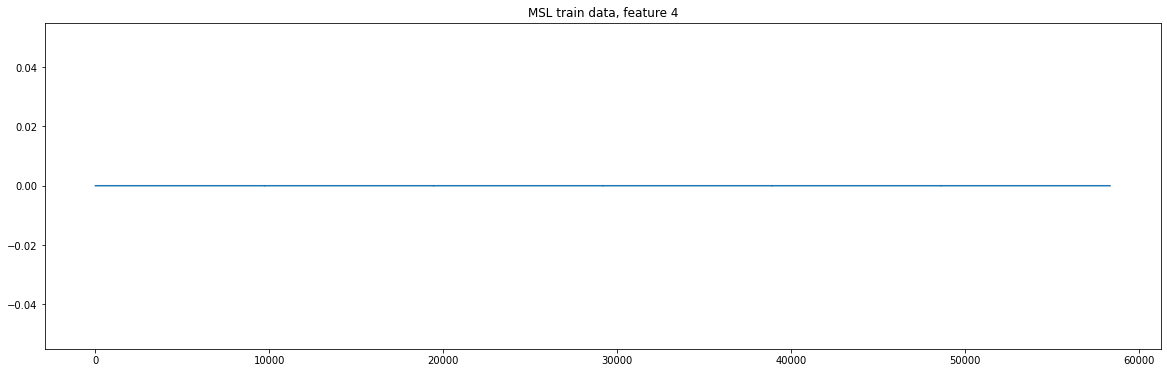

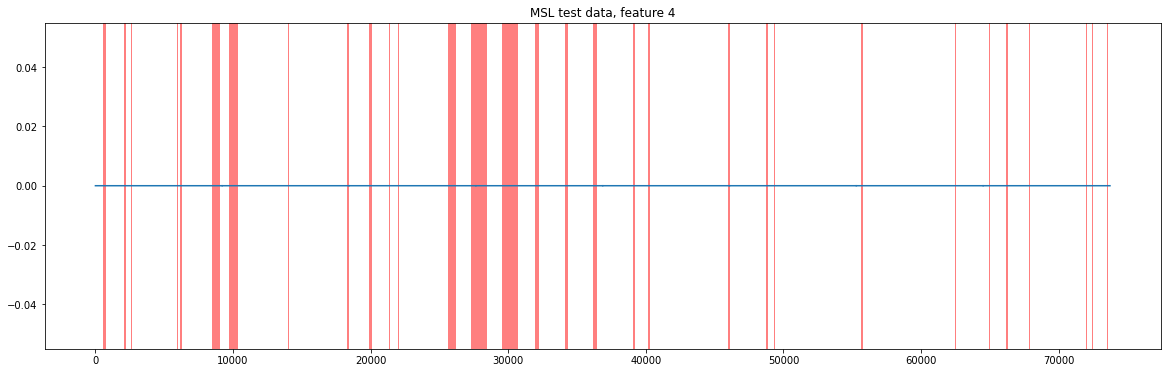

In [13]:
C = 4
dataset = "MSL"
datafactory.visualize_dataset(train_dataset.X, train_dataset.y, test_dataset.X, test_dataset.y, dataset_name=dataset, feature_idx=C)

In [14]:
train_X, train_y, test_X, test_y = train_dataset.X, train_dataset.y, test_dataset.X, test_dataset.y

## Load Model

In [15]:
trainer = MLP_Trainer(
    args=args,
    logger=logger,
    train_loader=train_loader,
    test_loader=test_loader,
)

In [16]:
trainer.load(os.path.join("./checkpoints/MLP_MSL", f"best.pth"))

[2023-03-14 07:52:10,652] loading: ./checkpoints/MLP_MSL/best.pth @Trainer - torch.load_state_dict


In [17]:
next(iter(trainer.model.parameters())).device, next(iter(trainer.model.parameters())).requires_grad

(device(type='cuda', index=0), True)

## Training statistics

In [ ]:
train_iterator = tqdm(
    trainer.train_loader,
    total=len(trainer.train_loader),
    desc="calculating reconstruction errors",
    leave=True
)

recon_errors = []
with torch.no_grad():
    for i, batch_data in enumerate(train_iterator):
        X = batch_data[0].to(trainer.args.device)
        B, L, C = X.shape
        Xhat = trainer.model(X.reshape(B, L*C)).reshape(B, L, C)
        recon_error = torch.nn.functional.mse_loss(Xhat, X, reduction='none')
        recon_errors.append(recon_error)

recon_errors = torch.cat(recon_errors, axis=0)
print(recon_errors.shape)
train_error_dist = recon_errors.mean(dim=(1, 2))

calculating reconstruction errors:  49%|████▉     | 448/912 [00:00<00:00, 739.73it/s]

## Test statistics

In [ ]:
eval_iterator = tqdm(
    trainer.test_loader,
    total=len(trainer.test_loader),
    desc="calculating reconstruction errors",
    leave=True
)

anoscs_prev = []
Xhats_prev = []
with torch.no_grad():
    for i, batch_data in enumerate(eval_iterator):
        X, y = batch_data[0].to(trainer.args.device), batch_data[1].to(trainer.args.device)
        B, L, C = X.shape
        Xhat = trainer.model(X.reshape(B, L*C)).reshape(B, L, C)
        Xhats_prev.append(Xhat)        
        e = F.mse_loss(Xhat, X, reduction='none')
        anosc = e.mean(dim=2)
        anoscs_prev.append(anosc)

Xhats_prev = torch.cat(Xhats_prev, axis=0).detach().cpu().numpy()
anoscs_prev = torch.cat(anoscs_prev, axis=0).detach().cpu().numpy()

In [ ]:
thr = torch.quantile(train_error_dist, 0.95).item()
thr

## Thresholds

In [ ]:
train_100_threshold = torch.max(train_error_dist).item()
train_99_threshold = torch.quantile(train_error_dist, 0.99).item()
train_95_threshold = torch.quantile(train_error_dist, 0.95).item()
oracle_threshold = trainer.oracle_thresholding(gt=test_y, anomaly_scores=anoscs_prev.reshape(-1))
print(train_95_threshold, train_99_threshold, train_100_threshold, oracle_threshold,)

In [ ]:
# 95
print(get_summary_stats(test_dataset.y, anoscs_prev.reshape(-1) > train_95_threshold))
# 99
print(get_summary_stats(test_dataset.y, anoscs_prev.reshape(-1) > train_99_threshold))
# 100
print(get_summary_stats(test_dataset.y, anoscs_prev.reshape(-1) > train_100_threshold))
# oracle
print(get_summary_stats(test_dataset.y, anoscs_prev.reshape(-1) > oracle_threshold))

### Label-guided Online learning

In [ ]:
init_thr = torch.quantile(train_error_dist, 0.95).item()
thr = torch.tensor(init_thr, requires_grad=True)
thr

In [ ]:
eval_iterator = tqdm(
    trainer.test_loader,
    total=len(trainer.test_loader),
    desc="calculating reconstruction errors",
    leave=True
)

lr = 1e-02
TH_optimizer = torch.optim.SGD([thr]+[p for p in trainer.model.parameters()], lr=lr)
bce = torch.nn.BCELoss()

Xs = []
Xhats = []
yhats = []
anoscs=[]
thrs = []
preds = []
for i, batch_data in enumerate(eval_iterator):
    X, y = batch_data[0].to(trainer.args.device), batch_data[1].to(trainer.args.device)
    Xs.append(X)
    
    # infer
    B, L, C = X.shape
    Xhat = trainer.model(X.reshape(B, L*C)).reshape(B, L, C)
    Xhats.append(Xhat)
    
    e = F.mse_loss(Xhat, X, reduction='none')
    anosc = e.mean(dim=2)
    anoscs.append(anosc)
    thrs.append(thr.item())
    pred = (anosc > thr)
    preds.append(pred)
    
    # update
    TH_optimizer.zero_grad()
    yhat = torch.sigmoid(anosc-thr)
    yhats.append(yhat)
    cls_loss = bce(yhat, y.float())
    mask = ((y == 0).unsqueeze(2))
    recon_loss = (e*mask).mean()
    loss = cls_loss + recon_loss
    loss.backward()
    TH_optimizer.step()
    
Xs = torch.cat(Xs, axis=0).detach().cpu().numpy()    
Xhats = torch.cat(Xhats, axis=0).detach().cpu().numpy()
yhats = torch.cat(yhats, axis=0).detach().cpu().numpy()

anoscs = torch.cat(anoscs, axis=0).detach().cpu().numpy()
thrs = np.repeat(np.array(thrs), args.window_size*args.eval_batch_size)
preds = torch.cat(preds).reshape(-1).detach().cpu().numpy()

In [ ]:
print(test_y.shape, preds.shape)
get_summary_stats(test_y, preds)

In [ ]:
# plot abnormal
test_X, test_y = test_dataset.X, test_dataset.y

B, L, C = Xhats.shape

fig, ax = plt.subplots(6, 1, figsize=(20, 30))

for c in range(min(args.num_channels, 5)):
    # gt
    plot_anomaly(ax[c], test_y)
    
    # reconed
    ax[c].plot(Xhats_prev[:,:,c].reshape(-1), color="blue", label="reconed w/o online learning")
    ax[c].plot(Xhats[:,:,c].reshape(-1), linewidth=0.5, color="green", label="reconed w/ online learning")
    ax[c].plot(test_X[:, c], color="black", label="gt")
    ax[c].legend()

ax[5].set_ylim([-1, 20])
ax[5].plot(anoscs_prev.reshape(-1), label="anomaly score w/o online learning")
ax[5].plot(anoscs.reshape(-1), label="anomaly score w/ online learning")
ax[5].axhline(train_95_threshold, color="purple", label="train 95% threshold")
ax[5].axhline(oracle_threshold, color="black", label="oracle threshold")
ax[5].plot(thrs, color="gold",label="dynamic threshold")
ax[5].legend()
plot_anomaly(ax[5], test_y)

plt.show()

In [ ]:
C = 7
plt.figure(figsize=(20, 6))
plt.title(f"{args.dataset}, channel {C}")
plt.plot(train_X[:, C], label="train")
plt.plot(test_X[:, C], label="test")
#plot_anomaly(plt, test_y)
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(20, 6))
plt.plot(anoscs_prev.reshape(-1), label="anomaly score (MLP, recon)")
plot_anomaly(plt, test_y)
plt.axhline(train_95_threshold, color="purple", label="train 95% threshold")
plt.axhline(oracle_threshold, color="black", label="oracle threshold")
plt.legend()
plt.show()